<a href="https://colab.research.google.com/github/ranjanguddu/Machine-Learning/blob/master/EVA4/Session-12/Assignment-12A_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount the Google Drive**

In [0]:
# let's mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/EVA4/')
! ls -l

total 35
-rw------- 1 root root  1717 Apr 19 06:49 Albumentation_Process.py
-rw------- 1 root root  1315 Apr 17 17:46 Asgmnt_12_DataGenerator.py
-rw------- 1 root root   564 Apr 13 08:48 DataLoaders.py
-rw------- 1 root root   529 Apr 16 15:05 Denorm.py
-rw------- 1 root root   783 Apr 17 17:47 Display.py
drwx------ 3 root root  4096 Apr 18 13:40 models
-rw------- 1 root root  1003 Apr 17 20:33 Model_Test.py
-rw------- 1 root root  1982 Apr 19 06:52 Model_Train.py
drwx------ 2 root root  4096 Apr 19 06:50 __pycache__
-rw------- 1 root root 13570 Apr 19 06:49 Schedule_Prog.py
drwx------ 5 root root  4096 Apr 19 05:05 tiny-imagenet-200


In [0]:
! pip install scipy==1.1.0

**Code to download ths Tiny ImageNET-200 Dataset**

In [0]:
import zipfile
import requests

from io import StringIO, BytesIO
def download_images(url):
  if(os.path.isdir("tiny-imagenet-200.zip")):
    print("Images already downloaded")
    return

  r = requests.get(url, stream=True)
  print('Downloading the dataset through ' +url)

  zip_ref = zipfile.ZipFile(BytesIO(r.content))
  zip_ref.extractall('./')
  zip_ref.close()

In [0]:
url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
download_images(url)

**All Import function**

In [0]:
import time

import numpy as np
from torchvision import datasets, transforms
import torch

import matplotlib.pyplot as plt
from matplotlib import pyplot


import torchvision
import torch.nn as nn
import torch.optim as optim

**Code to divide the Dataset in train and test**

In [0]:
import time
import scipy.ndimage as nd
from skimage import io
import numpy as np

path = '/content/drive/My Drive/EVA4/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [nd.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), mode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(nd.imread( path + 'val/images/{}'.format(img_name) ,mode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


finished loading data, in 137.89163279533386 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


In [0]:
mean,std = (0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)

norm_mean_std=[mean,std]

**Conacatenate both train and test data**

In [0]:
data = np.concatenate((train_data,test_data))
labels = np.concatenate((train_labels,test_labels))

labels= np.argmax(labels, axis=1) # get the index of the labels as the label is in one hot encoded form


print(labels.shape)
print(data.shape)


(110000,)
(110000, 64, 64, 3)


**Shuffle the entire data**

In [0]:
def shuffle_data(data, labels ):
    size = len(data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    return data[train_idx], labels[train_idx]
  
data, labels = shuffle_data(data, labels)

print(labels.shape)
print(data.shape)

(110000,)
(110000, 64, 64, 3)


**Code to Augmnent Train and Test Data**

In [0]:
from Albumentation_Process import Albumentations
train_transforms = Albumentations(norm_mean_std,Rotate=(-10.0,10.0),Padding=True,H_F=True, V_F =None,Resize=None,R_Crop=True, cutout=(4,))
test_transforms = Albumentations(norm_mean_std)

in the init of Albumentation
Finally Append become:[<albumentations.augmentations.transforms.Rotate object at 0x7fb5d2e7ef60>, <albumentations.augmentations.transforms.PadIfNeeded object at 0x7fb5c1e266d8>, <albumentations.augmentations.transforms.RandomCrop object at 0x7fb5d2e95048>, <albumentations.augmentations.transforms.HorizontalFlip object at 0x7fb5d2e95080>, <albumentations.augmentations.transforms.Normalize object at 0x7fb5d2e950b8>, <albumentations.augmentations.transforms.Cutout object at 0x7fb5d2e950f0>, <albumentations.pytorch.transforms.ToTensor object at 0x7fb5d2e95160>]
in the init of Albumentation
Finally Append become:[<albumentations.augmentations.transforms.Normalize object at 0x7fb5bf7bfba8>, <albumentations.pytorch.transforms.ToTensor object at 0x7fb5bf7bfbe0>]


**Code to seggregate the entire data in 70:30 ratio**

In [0]:
from Asgmnt_12_DataGenerator import TinyImageNet

training_data = TinyImageNet(data[0:77000, :], labels[0:77000],type_data="train", transform=train_transforms)
testing_data = TinyImageNet(data[77000:110000, :], labels[77000:110000], type_data="test", transform=test_transforms)

Train Data Image Shape:(77000, 64, 64, 3)
Train Label Label Shape:(77000,)
Test Data Image Shape:(33000, 64, 64, 3)
Test Data Label Shape:(33000,)


**Data Loader to load the data**

In [0]:
import DataLoaders
loader = DataLoaders.DataLoader(batch_size=512)

# train dataloader
train_loader = loader.load(training_data)

# test dataloader
test_loader = loader.load(testing_data)

**Displaying few train imagaes which is augmented**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

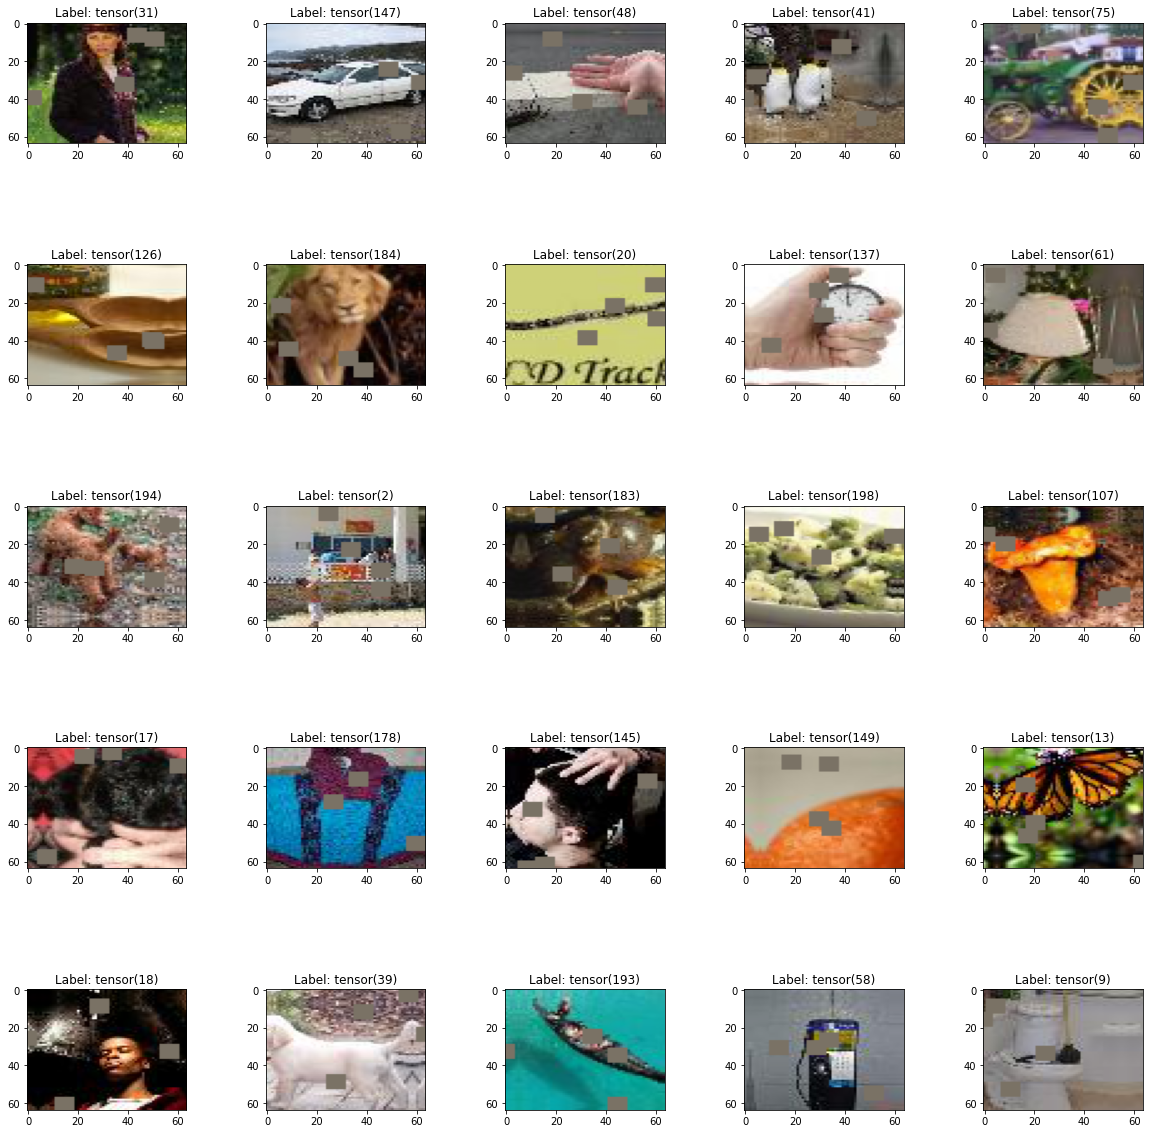

In [0]:
from Display import Display_Sample_Image

Display_Sample_Image(mean, std, train_loader)


**Display few Test Images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

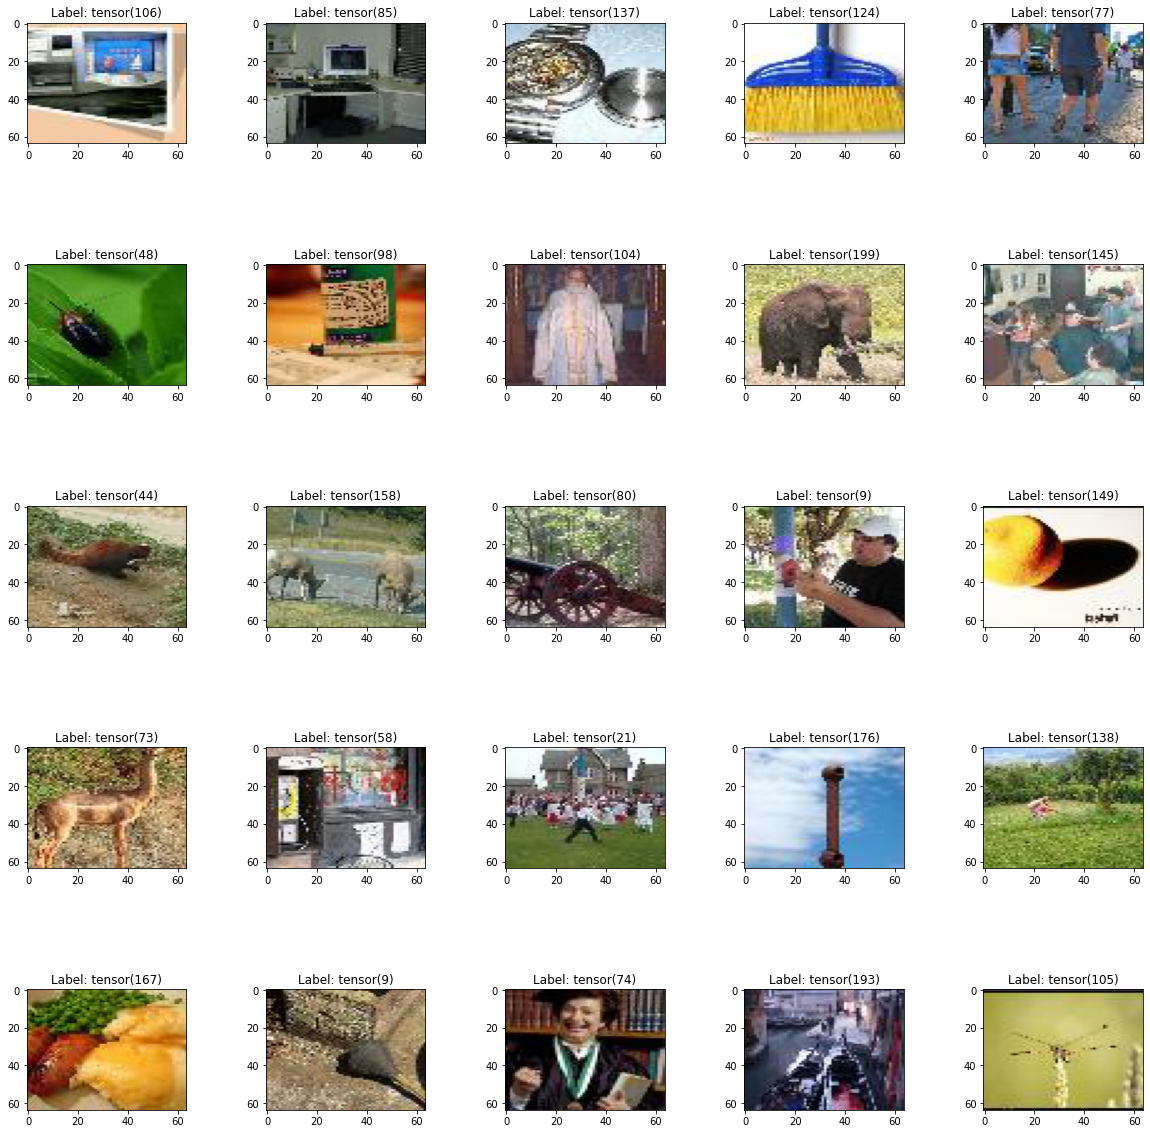

In [0]:
Display_Sample_Image(mean, std, test_loader)

In [0]:
from models.ResNet18_for_64 import ResNet18
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1

In [0]:
max_lr = 0.105
min_lr = max_lr/10

In [0]:
lr_s = np.interp(np.arange(50), [0, 9, 39, 50], [min_lr, max_lr, min_lr, 0])
mtm_s = np.interp(np.arange(50), [0, 9, 39, 50], [0.95, 0.8, 0.95, 0.95])



**Train The MODEL**

In [0]:
from Model_Train import train
from Model_Test import test
from Schedule_Prog import ListScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time


lr = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay = 1e-3)
scheduler = ListScheduler(optimizer, lrs=lr_s, momentums=mtm_s)


def run( epoch,l1_decay=0, l2_decay=0, ):
  
  Epochs = epoch
  test_losses = []
  test_accs = []
  train_losses = []
  train_accs = []
  
  
  print("\n")
  for epoch in range(Epochs):
      t0=time.time()
      print("EPOCH:", epoch+1)
      current_lr = [g['lr'] for g in optimizer.param_groups]
      current_m = [g['momentum'] for g in optimizer.param_groups]
      print('LR: {}, M : {}'.format(current_lr, current_m))

      train(model, device,train_loader, criterion, optimizer, epoch, l1_decay,l2_decay)
      test(model, device, test_loader, criterion)

      scheduler.step()
      t1= time.time()
      print("Time taken in epoch {} is {:.2f} Seconds\n".format(epoch+1, (t1-t0)))



In [0]:
run(epoch = 50, l1_decay=2e-05, l2_decay= 0.002)

  0%|          | 0/151 [00:00<?, ?it/s]



EPOCH: 1
LR: [0.010499999999999999], M : [0.9500000000000001]


L2_loss=634.2332153320312 L1_loss=214594.796875 Loss=10.034523010253906 Batch_id=150 Accuracy=3.09: 100%|██████████| 151/151 [00:54<00:00,  2.78it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0091, Accuracy: 2005/33000 (6.08%)

Time taken in epoch 1 is 61.33 Seconds

EPOCH: 2
LR: [0.020999999999999998], M : [0.9333333333333333]


L2_loss=593.677001953125 L1_loss=194107.75 Loss=9.040718078613281 Batch_id=150 Accuracy=9.35: 100%|██████████| 151/151 [00:54<00:00,  2.76it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 4001/33000 (12.12%)

Time taken in epoch 2 is 62.04 Seconds

EPOCH: 3
LR: [0.0315], M : [0.9166666666666665]


L2_loss=549.0427856445312 L1_loss=172077.046875 Loss=8.437975883483887 Batch_id=150 Accuracy=15.01: 100%|██████████| 151/151 [00:56<00:00,  2.68it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 5887/33000 (17.84%)

Time taken in epoch 3 is 63.91 Seconds

EPOCH: 4
LR: [0.041999999999999996], M : [0.9]


L2_loss=503.4169006347656 L1_loss=150285.84375 Loss=7.590619087219238 Batch_id=150 Accuracy=18.48: 100%|██████████| 151/151 [00:55<00:00,  2.70it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 6433/33000 (19.49%)

Time taken in epoch 4 is 63.06 Seconds

EPOCH: 5
LR: [0.052500000000000005], M : [0.8833333333333333]


L2_loss=458.8254089355469 L1_loss=129858.484375 Loss=7.125483989715576 Batch_id=150 Accuracy=21.24: 100%|██████████| 151/151 [00:55<00:00,  2.70it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 6296/33000 (19.08%)

Time taken in epoch 5 is 63.25 Seconds

EPOCH: 6
LR: [0.063], M : [0.8666666666666667]


L2_loss=416.5317687988281 L1_loss=111445.7734375 Loss=6.551546096801758 Batch_id=150 Accuracy=23.48: 100%|██████████| 151/151 [00:55<00:00,  2.70it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 6778/33000 (20.54%)

Time taken in epoch 6 is 63.13 Seconds

EPOCH: 7
LR: [0.0735], M : [0.85]


L2_loss=377.27471923828125 L1_loss=95278.609375 Loss=5.943365097045898 Batch_id=150 Accuracy=25.46: 100%|██████████| 151/151 [00:56<00:00,  2.69it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0066, Accuracy: 7974/33000 (24.16%)

Time taken in epoch 7 is 63.32 Seconds

EPOCH: 8
LR: [0.084], M : [0.8333333333333334]


L2_loss=341.4439697265625 L1_loss=81449.0078125 Loss=5.469176292419434 Batch_id=150 Accuracy=27.02: 100%|██████████| 151/151 [00:56<00:00,  2.69it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0067, Accuracy: 7946/33000 (24.08%)

Time taken in epoch 8 is 63.37 Seconds

EPOCH: 9
LR: [0.0945], M : [0.8166666666666667]


L2_loss=309.5035095214844 L1_loss=70000.96875 Loss=4.9681010246276855 Batch_id=150 Accuracy=28.04: 100%|██████████| 151/151 [00:55<00:00,  2.71it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0065, Accuracy: 8290/33000 (25.12%)

Time taken in epoch 9 is 63.02 Seconds

EPOCH: 10
LR: [0.10499999999999998], M : [0.8]


L2_loss=281.55816650390625 L1_loss=60762.43359375 Loss=4.652071475982666 Batch_id=150 Accuracy=28.96: 100%|██████████| 151/151 [00:56<00:00,  2.69it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0067, Accuracy: 7656/33000 (23.20%)

Time taken in epoch 10 is 63.63 Seconds

EPOCH: 11
LR: [0.10185], M : [0.805]


L2_loss=257.9259338378906 L1_loss=53579.88671875 Loss=4.669284343719482 Batch_id=150 Accuracy=30.01: 100%|██████████| 151/151 [00:55<00:00,  2.70it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 6431/33000 (19.49%)

Time taken in epoch 11 is 63.15 Seconds

EPOCH: 12
LR: [0.0987], M : [0.81]


L2_loss=238.45533752441406 L1_loss=48242.69921875 Loss=4.771346569061279 Batch_id=150 Accuracy=30.82: 100%|██████████| 151/151 [00:56<00:00,  2.69it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0064, Accuracy: 8630/33000 (26.15%)

Time taken in epoch 12 is 63.32 Seconds

EPOCH: 13
LR: [0.09555], M : [0.8150000000000001]


L2_loss=222.59396362304688 L1_loss=44371.078125 Loss=4.443915843963623 Batch_id=150 Accuracy=31.69: 100%|██████████| 151/151 [00:56<00:00,  2.68it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 7152/33000 (21.67%)

Time taken in epoch 13 is 63.69 Seconds

EPOCH: 14
LR: [0.0924], M : [0.8200000000000001]


L2_loss=210.05734252929688 L1_loss=41607.640625 Loss=4.335766792297363 Batch_id=150 Accuracy=32.56: 100%|██████████| 151/151 [00:56<00:00,  2.69it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0065, Accuracy: 8595/33000 (26.05%)

Time taken in epoch 14 is 63.44 Seconds

EPOCH: 15
LR: [0.08925], M : [0.8250000000000001]


L2_loss=199.79502868652344 L1_loss=39552.65625 Loss=4.288839817047119 Batch_id=150 Accuracy=33.03: 100%|██████████| 151/151 [00:56<00:00,  2.65it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0066, Accuracy: 8012/33000 (24.28%)

Time taken in epoch 15 is 64.32 Seconds

EPOCH: 16
LR: [0.0861], M : [0.8300000000000001]


L2_loss=191.8460235595703 L1_loss=38222.65234375 Loss=4.402889728546143 Batch_id=150 Accuracy=33.70: 100%|██████████| 151/151 [00:56<00:00,  2.69it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 10033/33000 (30.40%)

Time taken in epoch 16 is 63.61 Seconds

EPOCH: 17
LR: [0.08295], M : [0.835]


L2_loss=185.80332946777344 L1_loss=37380.4765625 Loss=4.017292022705078 Batch_id=150 Accuracy=34.11: 100%|██████████| 151/151 [00:56<00:00,  2.67it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0063, Accuracy: 8834/33000 (26.77%)

Time taken in epoch 17 is 63.97 Seconds

EPOCH: 18
LR: [0.0798], M : [0.84]


L2_loss=181.3264923095703 L1_loss=36931.12109375 Loss=3.8846445083618164 Batch_id=150 Accuracy=34.91: 100%|██████████| 151/151 [00:56<00:00,  2.67it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0060, Accuracy: 9886/33000 (29.96%)

Time taken in epoch 18 is 63.89 Seconds

EPOCH: 19
LR: [0.07665], M : [0.845]


L2_loss=178.3663330078125 L1_loss=36737.3359375 Loss=3.843540668487549 Batch_id=150 Accuracy=35.36: 100%|██████████| 151/151 [00:56<00:00,  2.65it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0062, Accuracy: 9524/33000 (28.86%)

Time taken in epoch 19 is 64.18 Seconds

EPOCH: 20
LR: [0.0735], M : [0.85]


L2_loss=176.55845642089844 L1_loss=36817.3671875 Loss=3.621333122253418 Batch_id=150 Accuracy=36.17: 100%|██████████| 151/151 [00:56<00:00,  2.65it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 10162/33000 (30.79%)

Time taken in epoch 20 is 64.21 Seconds

EPOCH: 21
LR: [0.07035], M : [0.855]


L2_loss=175.3324432373047 L1_loss=36932.88671875 Loss=3.9001123905181885 Batch_id=150 Accuracy=36.65: 100%|██████████| 151/151 [00:57<00:00,  2.65it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0060, Accuracy: 9974/33000 (30.22%)

Time taken in epoch 21 is 64.48 Seconds

EPOCH: 22
LR: [0.0672], M : [0.86]


L2_loss=174.95494079589844 L1_loss=37093.30859375 Loss=3.8298416137695312 Batch_id=150 Accuracy=36.85: 100%|██████████| 151/151 [00:57<00:00,  2.63it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0058, Accuracy: 10578/33000 (32.05%)

Time taken in epoch 22 is 64.77 Seconds

EPOCH: 23
LR: [0.06405], M : [0.865]


L2_loss=174.55210876464844 L1_loss=37102.6328125 Loss=3.882239818572998 Batch_id=150 Accuracy=37.97: 100%|██████████| 151/151 [00:56<00:00,  2.66it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 10226/33000 (30.99%)

Time taken in epoch 23 is 64.09 Seconds

EPOCH: 24
LR: [0.06089999999999999], M : [0.87]


L2_loss=175.0392303466797 L1_loss=37217.2109375 Loss=3.4056057929992676 Batch_id=150 Accuracy=37.92: 100%|██████████| 151/151 [00:57<00:00,  2.64it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0060, Accuracy: 10358/33000 (31.39%)

Time taken in epoch 24 is 64.61 Seconds

EPOCH: 25
LR: [0.057749999999999996], M : [0.875]


L2_loss=175.33995056152344 L1_loss=37216.34765625 Loss=3.714587688446045 Batch_id=150 Accuracy=38.87: 100%|██████████| 151/151 [00:57<00:00,  2.63it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0062, Accuracy: 9363/33000 (28.37%)

Time taken in epoch 25 is 65.17 Seconds

EPOCH: 26
LR: [0.054599999999999996], M : [0.88]


L2_loss=175.71861267089844 L1_loss=37231.86328125 Loss=3.6237940788269043 Batch_id=150 Accuracy=39.46: 100%|██████████| 151/151 [00:57<00:00,  2.64it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0058, Accuracy: 10875/33000 (32.95%)

Time taken in epoch 26 is 64.70 Seconds

EPOCH: 27
LR: [0.051449999999999996], M : [0.885]


L2_loss=176.57168579101562 L1_loss=37288.84765625 Loss=3.477593421936035 Batch_id=150 Accuracy=39.90: 100%|██████████| 151/151 [00:56<00:00,  2.68it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 10377/33000 (31.45%)

Time taken in epoch 27 is 63.54 Seconds

EPOCH: 28
LR: [0.048299999999999996], M : [0.89]


L2_loss=177.36012268066406 L1_loss=37351.59765625 Loss=3.8654625415802 Batch_id=150 Accuracy=40.22: 100%|██████████| 151/151 [00:54<00:00,  2.76it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0063, Accuracy: 9540/33000 (28.91%)

Time taken in epoch 28 is 61.70 Seconds

EPOCH: 29
LR: [0.045149999999999996], M : [0.895]


L2_loss=178.02154541015625 L1_loss=37329.90625 Loss=3.675926923751831 Batch_id=150 Accuracy=41.19: 100%|██████████| 151/151 [00:54<00:00,  2.76it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0054, Accuracy: 12106/33000 (36.68%)

Time taken in epoch 29 is 61.70 Seconds

EPOCH: 30
LR: [0.041999999999999996], M : [0.9]


L2_loss=178.95066833496094 L1_loss=37433.2421875 Loss=3.7592053413391113 Batch_id=150 Accuracy=41.41: 100%|██████████| 151/151 [00:55<00:00,  2.74it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0057, Accuracy: 11067/33000 (33.54%)

Time taken in epoch 30 is 62.22 Seconds

EPOCH: 31
LR: [0.038849999999999996], M : [0.905]


L2_loss=179.5254364013672 L1_loss=37471.62109375 Loss=3.5316975116729736 Batch_id=150 Accuracy=42.24: 100%|██████████| 151/151 [00:54<00:00,  2.79it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0054, Accuracy: 11932/33000 (36.16%)

Time taken in epoch 31 is 61.13 Seconds

EPOCH: 32
LR: [0.035699999999999996], M : [0.91]


L2_loss=179.9939727783203 L1_loss=37435.34765625 Loss=3.433149576187134 Batch_id=150 Accuracy=43.01: 100%|██████████| 151/151 [00:54<00:00,  2.75it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 11507/33000 (34.87%)

Time taken in epoch 32 is 62.29 Seconds

EPOCH: 33
LR: [0.032549999999999996], M : [0.9149999999999999]


L2_loss=180.32418823242188 L1_loss=37461.5234375 Loss=3.539304494857788 Batch_id=150 Accuracy=43.69: 100%|██████████| 151/151 [00:54<00:00,  2.76it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0054, Accuracy: 11953/33000 (36.22%)

Time taken in epoch 33 is 61.62 Seconds

EPOCH: 34
LR: [0.029399999999999996], M : [0.9199999999999999]


L2_loss=180.73291015625 L1_loss=37444.8203125 Loss=3.5912160873413086 Batch_id=150 Accuracy=44.14: 100%|██████████| 151/151 [00:54<00:00,  2.78it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 12730/33000 (38.58%)

Time taken in epoch 34 is 61.22 Seconds

EPOCH: 35
LR: [0.026249999999999996], M : [0.9249999999999999]


L2_loss=180.62222290039062 L1_loss=37352.97265625 Loss=3.260881185531616 Batch_id=150 Accuracy=45.64: 100%|██████████| 151/151 [00:54<00:00,  2.78it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 11622/33000 (35.22%)

Time taken in epoch 35 is 61.32 Seconds

EPOCH: 36
LR: [0.023099999999999996], M : [0.9299999999999999]


L2_loss=180.5015411376953 L1_loss=37262.3125 Loss=3.435020923614502 Batch_id=150 Accuracy=46.49: 100%|██████████| 151/151 [00:54<00:00,  2.78it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0054, Accuracy: 12064/33000 (36.56%)

Time taken in epoch 36 is 61.34 Seconds

EPOCH: 37
LR: [0.019949999999999996], M : [0.9349999999999999]


L2_loss=180.56747436523438 L1_loss=37197.70703125 Loss=3.253716468811035 Batch_id=150 Accuracy=46.91: 100%|██████████| 151/151 [00:53<00:00,  2.81it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0050, Accuracy: 13307/33000 (40.32%)

Time taken in epoch 37 is 60.57 Seconds

EPOCH: 38
LR: [0.016799999999999995], M : [0.9399999999999998]


L2_loss=179.92474365234375 L1_loss=36968.01171875 Loss=3.3215012550354004 Batch_id=150 Accuracy=48.64: 100%|██████████| 151/151 [00:53<00:00,  2.81it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0050, Accuracy: 13251/33000 (40.15%)

Time taken in epoch 38 is 60.75 Seconds

EPOCH: 39
LR: [0.013649999999999995], M : [0.9449999999999998]


L2_loss=179.25213623046875 L1_loss=36675.71484375 Loss=3.113722801208496 Batch_id=150 Accuracy=49.85: 100%|██████████| 151/151 [00:53<00:00,  2.82it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0050, Accuracy: 13582/33000 (41.16%)

Time taken in epoch 39 is 60.48 Seconds

EPOCH: 40
LR: [0.010499999999999999], M : [0.9500000000000001]


L2_loss=178.2010040283203 L1_loss=36213.296875 Loss=3.306410312652588 Batch_id=150 Accuracy=51.91: 100%|██████████| 151/151 [00:54<00:00,  2.79it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0047, Accuracy: 14291/33000 (43.31%)

Time taken in epoch 40 is 61.25 Seconds

EPOCH: 41
LR: [0.009545454545454544], M : [0.9500000000000001]


L2_loss=177.0960235595703 L1_loss=35951.20703125 Loss=2.968400239944458 Batch_id=150 Accuracy=53.53: 100%|██████████| 151/151 [00:53<00:00,  2.80it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0048, Accuracy: 13974/33000 (42.35%)

Time taken in epoch 41 is 60.80 Seconds

EPOCH: 42
LR: [0.00859090909090909], M : [0.9500000000000001]


L2_loss=176.3030548095703 L1_loss=35754.78125 Loss=2.8569281101226807 Batch_id=150 Accuracy=54.90: 100%|██████████| 151/151 [00:53<00:00,  2.80it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0047, Accuracy: 14418/33000 (43.69%)

Time taken in epoch 42 is 60.96 Seconds

EPOCH: 43
LR: [0.007636363636363636], M : [0.9500000000000001]


L2_loss=175.4247589111328 L1_loss=35505.3203125 Loss=2.9368927478790283 Batch_id=150 Accuracy=56.08: 100%|██████████| 151/151 [00:53<00:00,  2.81it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0046, Accuracy: 14622/33000 (44.31%)

Time taken in epoch 43 is 60.67 Seconds

EPOCH: 44
LR: [0.006681818181818181], M : [0.9500000000000001]


L2_loss=174.48597717285156 L1_loss=35275.1171875 Loss=2.791299819946289 Batch_id=150 Accuracy=57.97: 100%|██████████| 151/151 [00:53<00:00,  2.80it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0048, Accuracy: 14212/33000 (43.07%)

Time taken in epoch 44 is 60.63 Seconds

EPOCH: 45
LR: [0.005727272727272727], M : [0.9500000000000001]


L2_loss=173.51095581054688 L1_loss=34982.1953125 Loss=2.774423599243164 Batch_id=150 Accuracy=59.91: 100%|██████████| 151/151 [00:53<00:00,  2.82it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0046, Accuracy: 15043/33000 (45.58%)

Time taken in epoch 45 is 60.31 Seconds

EPOCH: 46
LR: [0.004772727272727272], M : [0.9500000000000001]


L2_loss=172.5160369873047 L1_loss=34666.6640625 Loss=2.6627426147460938 Batch_id=150 Accuracy=61.80: 100%|██████████| 151/151 [00:53<00:00,  2.82it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0044, Accuracy: 15540/33000 (47.09%)

Time taken in epoch 46 is 60.37 Seconds

EPOCH: 47
LR: [0.003818181818181818], M : [0.9500000000000001]


L2_loss=171.39959716796875 L1_loss=34298.21484375 Loss=2.3633062839508057 Batch_id=150 Accuracy=64.71: 100%|██████████| 151/151 [00:53<00:00,  2.83it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0046, Accuracy: 15158/33000 (45.93%)

Time taken in epoch 47 is 60.34 Seconds

EPOCH: 48
LR: [0.0028636363636363633], M : [0.9500000000000001]


L2_loss=170.39784240722656 L1_loss=33907.73046875 Loss=2.6155941486358643 Batch_id=150 Accuracy=67.82: 100%|██████████| 151/151 [00:53<00:00,  2.84it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0043, Accuracy: 15950/33000 (48.33%)

Time taken in epoch 48 is 59.97 Seconds

EPOCH: 49
LR: [0.001909090909090909], M : [0.9500000000000001]


L2_loss=169.48175048828125 L1_loss=33527.57421875 Loss=2.275477170944214 Batch_id=150 Accuracy=71.03: 100%|██████████| 151/151 [00:53<00:00,  2.82it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0042, Accuracy: 16420/33000 (49.76%)

Time taken in epoch 49 is 60.25 Seconds

EPOCH: 50
LR: [0.0009545454545454544], M : [0.9500000000000001]


L2_loss=168.88787841796875 L1_loss=33247.42578125 Loss=2.0396666526794434 Batch_id=150 Accuracy=74.17: 100%|██████████| 151/151 [00:53<00:00,  2.82it/s]


Test set: Average loss: 0.0041, Accuracy: 16649/33000 (50.45%)

Time taken in epoch 50 is 60.28 Seconds



**Saved The MODEL**

In [0]:
torch.save(model.state_dict(),'tiny-image-weight.pt')

**Code to classify Misclassified and correct classified Images**

In [0]:
misclassified_imgs=[]
correct_imgs=[]


with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            misclassified_inds = (is_correct==0).nonzero()[:,0]
            for mis_ind in misclassified_inds:
              if len(misclassified_imgs) == 25:
                break
              misclassified_imgs.append({"target": target[mis_ind].cpu().numpy(),"pred": pred[mis_ind][0].cpu().numpy(),"img": data[mis_ind]})
              
            correct_inds = (is_correct==1).nonzero()[:,0]
            for ind in correct_inds:
              if len(correct_imgs) == 25:
                break
              correct_imgs.append({"target": target[ind].cpu().numpy(),"pred": pred[ind][0].cpu().numpy(),"img": data[ind]})
        print("No. of misclassified items: {} \n No. of correctly classified item is:{}".format(len(misclassified_imgs),len(correct_imgs)))
        print(type(misclassified_imgs[0]))

**Displaying misclassified and correcly classified image**

In [0]:
from Denorm import unnormalize
import matplotlib.pyplot as plt
from matplotlib import pyplot

def print_image(result_category=None):
  #print(result_category)
  print("\n\n\n")
  figure = plt.figure(figsize=(10, 10))
  figure.subplots_adjust(hspace=1, wspace=0.5)
  for i in range(25):
    data = result_category[i].get("img")
    t = (result_category[i].get("target"))
    p = (result_category[i].get("pred")) 
  
    d=data.cpu()
    plt.subplot(5,5,i+1)
    plt.imshow(unnormalize(mean, std, d), aspect='auto')
    pyplot.axis("off")
 
    plt.title("Predicted: %s\nActual: %s" % (p, t))
    plt.xticks([])
    plt.yticks([])
  
  plt.show()

**Misclassified iMages**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


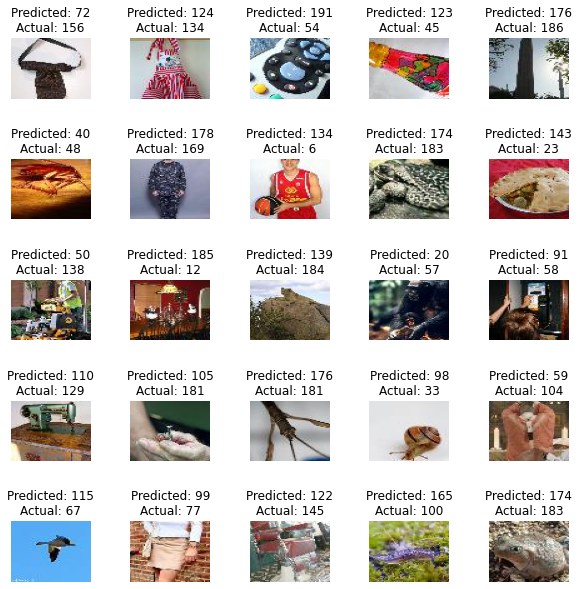

In [0]:
print_image(misclassified_imgs)

**Correcly classified Images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


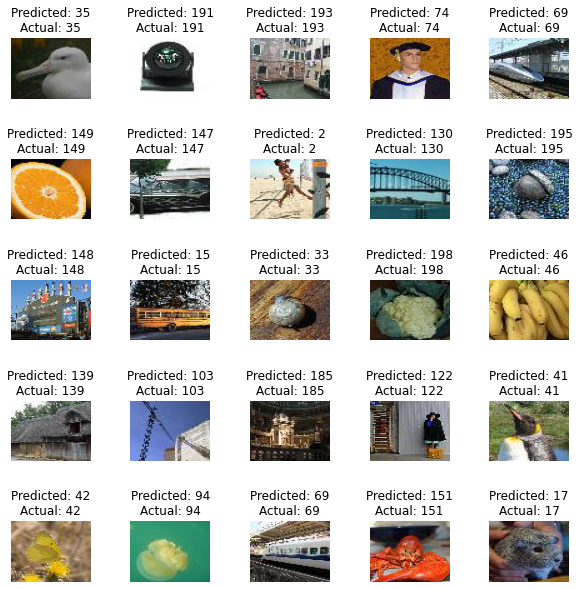

In [0]:
print_image(correct_imgs)